# Computer Vision for Distracted Driving Detection

## Objective
The goal of this project is to utilize neural networks to accurately classify driver activities related to distracted driving. The model will classify activities into the following categories:

- c0: Safe driving
- c1: Texting - right
- c2: Talking on the phone - right
- c3: Texting - left
- c4: Talking on the phone - left
- c5: Operating the radio
- c6: Drinking
- c7: Reaching behind
- c8: Hair and makeup
- c9: Talking to passenger

## Process Overview
This task will be approached in the following steps:

1. Transfer learning with the VGG16 base model will be applied as the initial approach.
2. A convolutional neural network (CNN) will be developed from scratch, utilizing the Adam optimizer.
3. Finally, the results of both approaches will be evaluated and compared.

## Dataset
The dataset used in this notebook can be accessed from the following link:
[Dataset Link](https://drive.google.com/file/d/1l1pN5ZQ6gELeWR8H1uZr0V05hP3gfpg_/view?usp=sharing)

By utilizing computer vision techniques and neural networks, this project aims to contribute to the development of effective systems for detecting and preventing distracted driving behaviors.


In [1]:

import tensorflow as tf

from tensorflow import keras

from keras import backend as K

print('Keras version:',keras.__version__)

Keras version: 2.12.0


### Prepare the Data
Before we can train the model, we need to prepare the data.

In [2]:
import os
from keras.preprocessing.image import ImageDataGenerator

# Folder where training images are
training_folder_name = './imgs/train/'

# The folder contains a subfolder for each class of action
classes = sorted(os.listdir(training_folder_name))
print(classes)

# Our model will work with images of 128 x 128 pixels
pretrained_size = (128,128)
batch_size = 30

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

# The `ImageDataGenerator` is used for data augmentation and preprocessing.
# It rescales the pixel values of the images to be between 0 and 1 by dividing them by 255.
# It also splits the data into training and validation sets using a validation split of 0.3 (30% for validation).

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    training_folder_name,
    target_size=pretrained_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

# The `flow_from_directory` method generates batches of augmented/processed data from the specified directory.
# It sets the target size of the images to be resized to (128, 128) pixels.
# It uses a batch size of 30 and the class mode is set to 'categorical' for multi-class classification.
# The subset is set to 'training' to indicate that this generator is for training data.

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    training_folder_name,
    target_size=pretrained_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

# Similar to the training generator, the validation generator is created with the same parameters
# except that the subset is set to 'validation' to indicate that this generator is for validation data.


['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
Getting Data...
Preparing training dataset...
Found 15702 images belonging to 10 classes.
Preparing validation dataset...
Found 6722 images belonging to 10 classes.


# Using Transfer Learning - VGG16 Model
The VGG16 model, pre-trained on the ImageNet dataset, is a powerful image classifier. By leveraging its pre-trained weights and removing the top classification layer, we can repurpose it as a feature extractor, enabling efficient transfer learning for our specific task.

In [4]:
from keras.applications.vgg16 import VGG16
#Load the base model, not including its final connected layer, and set the input shape to match our images
base_model = VGG16(weights='imagenet', include_top=False, input_shape=train_generator.image_shape)

58889256/58889256 [==============================] - 3s 0us/step


### Freezing Pre-trained Layers and Adding Custom Output Layer
To leverage the already trained feature extraction layers, we freeze them to prevent further training. We then introduce a custom output layer that maps the model's output to the predictions for our specific classes.

In [5]:
from keras import Model
from keras.layers import Flatten, Dense
from keras import optimizers

# Freeze the already-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create layers for classification of our images
x = base_model.output
x = Flatten()(x)
prediction_layer = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=prediction_layer)

# Compile the model
opt = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Now print the full model, which will include the layers of the base model plus the dense layer we added
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

c:\Users\joegu\OneDrive\Desktop\MCSBT_Computer_Vision\Distracted_driver_detection\myenv\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Train the Model
With the layers of the CNN defined, we're ready to train the top layer using our image data. This will take a considerable amount of time on a CPU due to the complexity of the base model, so we'll train the model over only one epoch.

In [6]:
# Train the model over 1 epoch using 30-image batches and using the validation holdout dataset for validation
num_epochs = 1
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

C:\Users\joegu\AppData\Local\Temp\ipykernel_10728\356184921.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


523/523 [==============================] - 372s 711ms/step - loss: 0.4931 - accuracy: 0.8801 - val_loss: 0.1443 - val_accuracy: 0.9759


### Using the Trained Model
Now that we've trained the model, we can use it to predict the class of an image.

First we will define some helper functions to resize our images and to classify each image.

In [21]:
# Helper function to resize image
def resize_image(src_img, size=(128,128), bg_color="white"):
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)

    # Create a new image of the right shape
    new_image = Image.new("RGB", size, bg_color)

    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))

    # return the resized image
    return new_image

# Function to predict the class of an image
def predict_image(classifier, image_array):
    import numpy as np

    # We need to format the input to match the training data
    # The data generator loaded the values as floating point numbers
    # and normalized the pixel values, so...
    img_features = image_array.astype('float32')
    img_features /= 255

    # These are the classes our model can predict
    classnames = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

    # Predict the class of each input image
    predictions = classifier.predict(img_features)

    predicted_classes = []
    for prediction in predictions:
        # The prediction for each image is the probability for each class, e.g. [0.8, 0.1, 0.2]
        # So get the index of the highest probability
        class_idx = np.argmax(prediction)
        # And append the corresponding class name to the results
        predicted_classes.append(classnames[int(class_idx)])
    # Return the predictions
    return predicted_classes

print("Functions created - ready to use model for inference.")

Functions created - ready to use model for inference.


C:\Users\joegu\AppData\Local\Temp\ipykernel_10728\4050231234.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  src_img.thumbnail(size, Image.ANTIALIAS)


1/1 [==============================] - 0s 257ms/step


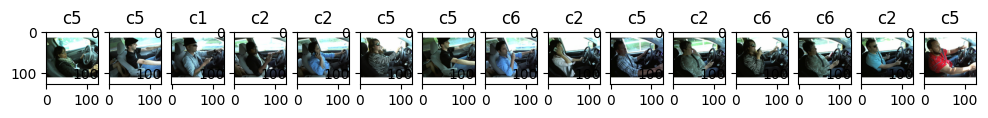

In [23]:
import os
from random import randint
import numpy as np
from PIL import Image
from keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

#get the list of test image files - created a small sample of 20 for test purposes, can otherwise use the 'test' folder which will be very time consuming
test_folder = './imgs/test_small/'
test_image_files = os.listdir(test_folder)

# Empty array on which to store the images
image_arrays = []

size = (128,128)
background_color="white"

fig = plt.figure(figsize=(12, 8))

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_folder, test_image_files[file_idx]))

    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size, background_color))

    # Add the image to the array of images
    image_arrays.append(resized_img)

# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(model, np.array(image_arrays))

# plot easch image with its corresponding prediction
for idx in range(len(predictions)):
    a=fig.add_subplot(1,len(predictions),idx+1)
    imgplot = plt.imshow(image_arrays[idx])
    a.set_title(predictions[idx])




## Model 2, creating our own CNN using Adam optimization

We will now follow a similar process as done in transfer learning, but instead of importing an existing powerful neural network, we will attempt to create one from scratch to evaluate the performance



### With our libraries and environment already set up from the previous exercise, we can begin with defining our new CNN using Adam optimization

In [31]:
# Importing the necessary libraries for the CNN model using Adam optimization
from keras.models import Sequential  # Importing the Sequential class from keras.models
from keras.layers import Conv2D, MaxPooling2D  # Importing Conv2D and MaxPooling2D layers from keras.layers
from keras.layers import Activation, Flatten, Dense  # Importing Activation, Flatten, and Dense layers from keras.layers
from keras import optimizers  # Importing the optimizers module from keras
import tensorflow as tf  # Importing the tensorflow library as tf

# Dense is the fully connected layer
# Flatten is used after all CNN layers and before the fully connected layer
# Conv2D is the 2D convolution layer
# MaxPooling2D is the 2D max pooling layer

# Define the model as a sequence of layers
model = Sequential()

# The input layer accepts an image and applies a convolution that uses 32 6x6 filters and a rectified linear unit activation function
model.add(Conv2D(32, (6, 6), input_shape=train_generator.image_shape, activation='relu'))

# Next, we'll add a max pooling layer with a 2x2 patch
model.add(MaxPooling2D(pool_size=(2, 2)))

# We can add as many layers as we think necessary - here we'll add another convolution layer and another max pooling layer
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Now we'll flatten the feature maps and generate an output layer with a predicted probability for each class
model.add(Flatten())
model.add(Dense(train_generator.num_classes, activation='softmax'))

# We'll use the ADAM optimizer
# Other optimizers can also be used, for example, SGD (stochastic gradient descent)
opt = tf.optimizers.Adam(learning_rate=0.001)

# With the layers defined, we can now compile the model for categorical (multi-class) classification
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Print the summary of the model, including the layer information and number of parameters
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 123, 123, 32)      3488      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 32)        36896     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 10)               

_________________________________________________________________
None


### Train the model 

After defining our model, we're ready to train our model using the image data. 

Again we will train using 1 epoch due to the CPU time required for practical demonstration purposes

In [32]:
# Train the model over 1 epoch using 15-image batches and using the validation holdout dataset for validation
num_epochs = 1
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

C:\Users\joegu\AppData\Local\Temp\ipykernel_10728\356184921.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


523/523 [==============================] - 132s 252ms/step - loss: 0.5762 - accuracy: 0.8136 - val_loss: 0.1115 - val_accuracy: 0.9677


### Evaluate the model 

After training our model, we're ready to validate its performance. We will use a confusion matrix to evaluate the model. 


Generating predictions from validation data...
1/1 [==============================] - 0s 78ms/step


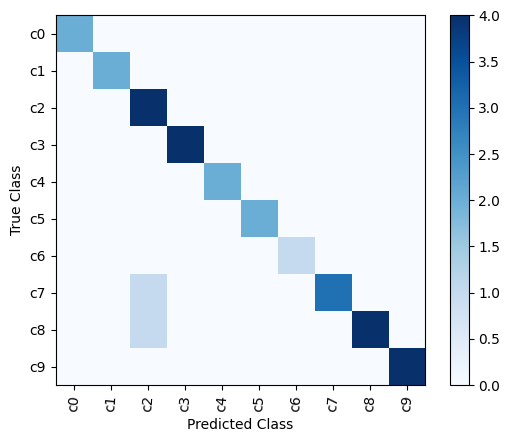

In [33]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# Use the model to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=85)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In the above chart we see our current model tends to incorrectly classify actions c7 and c8 as action c2. 

### Saving and testing the model

Now we can test our model using our previously defined helper functions to visually examine the performance

In [34]:
from keras.models import load_model

modelFileName = 'driver-action-classifier.h5'

model.save(modelFileName) # saves the trained model
print("Model saved.")

del model  # deletes the existing model variable

Model saved.


1/1 [==============================] - 0s 59ms/step


C:\Users\joegu\AppData\Local\Temp\ipykernel_10728\4050231234.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  src_img.thumbnail(size, Image.ANTIALIAS)


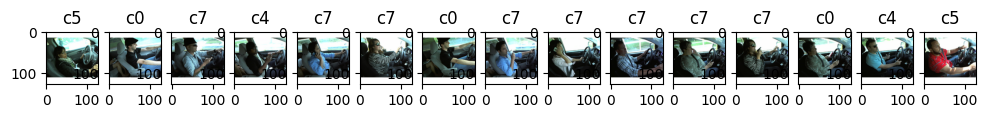

In [35]:
# load the saved model
modelFileName = 'driver-action-classifier.h5'
model = load_model(modelFileName) 

#get the list of test image files - created a small sample of 20 for test purposes, can otherwise use the 'test' folder which will be very time consuming
test_folder = './imgs/test_small/'
test_image_files = os.listdir(test_folder)

# Empty array on which to store the images
image_arrays = []

size = (128,128)
background_color="white"

fig = plt.figure(figsize=(12, 8))

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_folder, test_image_files[file_idx]))

    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size, background_color))

    # Add the image to the array of images
    image_arrays.append(resized_img)

# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(model, np.array(image_arrays))

# plot easch image with its corresponding prediction
for idx in range(len(predictions)):
    a=fig.add_subplot(1,len(predictions),idx+1)
    imgplot = plt.imshow(image_arrays[idx])
    a.set_title(predictions[idx])


# Results

### We have now created two neural networks which we can evaluate against eachother.

Model 1: A neural network created using transfer learning with the VGG16 model achieved an accuracy of 0.8801. Transfer learning allowed us to leverage the pre-trained VGG16 model's knowledge and parameters, resulting in a high level of accuracy.

Model 2: A convolutional neural network created from scratch using the Adam optimizer achieved an accuracy of 0.8136. While this model was trained from the ground up, it achieved a slightly lower accuracy compared to the transfer learning approach.


# Conclusion

In conclusion, the experiment comparing a custom-built neural network with a transfer learning approach using the VGG16 model demonstrated that transfer learning significantly reduces the effort required to achieve comparable performance, making it a valuable technique for leveraging pre-trained models in tasks with limited training data.
